# Assignment 3: Pytorch Segmentation + CAM
For this assignment, in the first part, we're going to use Deep Learning for a new task: semantic segmentation. In the second part, you will interpret networks with the class activation map (CAM) as discussed in classes.

## Short recap of  semantic segmentation
The goal of semantic segmentation is to classify each pixel of the image to a corresponding class of what the pixel represent. One major diference between semantic segmentation and classification is that for semantic segmentation, model output a label for each pixel instead of a single label for the whole image.

## CMP Facade Database and Visualize Samples
In this assignment, we use a new dataset named: CMP Facade Database for semantic segmentation. This dataset is made up with 606 rectified images of the facade of various buildings. The facades are from different cities arount the world with different architectural styles.

CMP Facade DB include 12 semantic classes:

* facade 
* molding
* cornice
* pillar
* window
* door
* sill
* blind
* balcony
* shop
* deco
* background

In this assignment, we should use a model to classify each pixel in images to one of these 12 classes.

For more detail about CMP Facade Dataset, if you are intereseted, please check: https://cmp.felk.cvut.cz/~tylecr1/facade/

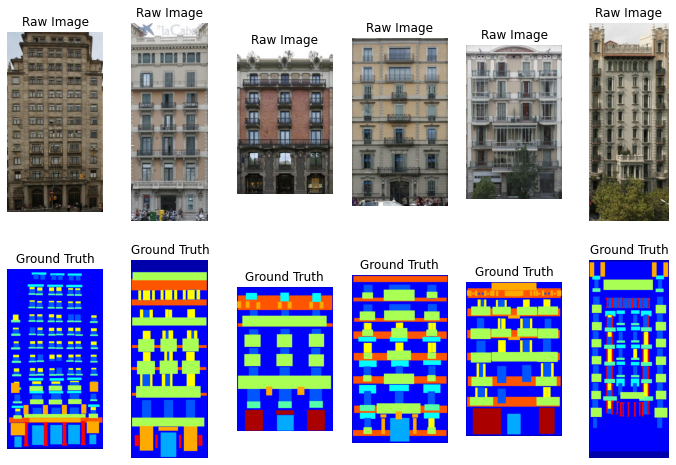

In [1]:
import matplotlib.pyplot as plt
import numpy as np

idxs = [1, 2, 5, 6, 7, 8]
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(12, 8))
for i, idx in enumerate(idxs):
    pic = plt.imread("dataset/base/cmp_b000{}.jpg".format(idx))
    label = plt.imread("dataset/base/cmp_b000{}.png".format(idx), format="PNG")

    axes[0][i].axis('off')
    axes[0][i].imshow(pic)
    axes[0][i].set_title("Raw Image")

    axes[1][i].imshow(label)
    axes[1][i].axis('off')
    axes[1][i].set_title("Ground Truth")

## Build Dataloader and Set Up Device

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.transforms as T
import PIL
from PIL import Image
import numpy as np
import os
# import os.path as osp

from FCN.dataset import CMP_Facade_DB

os.environ["CUDA_VISIBLE_DEVICES"]="0"


def get_full_list(
    root_dir,
    base_dir="base",
    extended_dir="extended",
):
    data_list = []
    for name in [base_dir, extended_dir]:
        data_dir = os.path.join(
            root_dir, name
        )
        data_list += sorted(
            os.path.join(data_dir, img_name) for img_name in
            filter(
                lambda x: x[-4:] == '.jpg',
                os.listdir(data_dir)
            )
        )
    return data_list

TRAIN_SIZE = 500
VAL_SIZE = 30
TEST_SIZE = 70
full_data_list = get_full_list("dataset")

train_data_set = CMP_Facade_DB(full_data_list[: TRAIN_SIZE])
val_data_set = CMP_Facade_DB(full_data_list[TRAIN_SIZE: TRAIN_SIZE + VAL_SIZE])
test_data_set = CMP_Facade_DB(full_data_list[TRAIN_SIZE + VAL_SIZE:])

print("Training Set Size:", len(train_data_set))
print("Validation Set Size:", len(val_data_set))
print("Test Set Size:", len(test_data_set))

train_loader = torch.utils.data.DataLoader(
    train_data_set, batch_size=1, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_data_set, batch_size=1, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_data_set, batch_size=1, shuffle=False
)



USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

Training Set Size: 500
Validation Set Size: 30
Test Set Size: 76
using device: cpu


## Fully Convolutional Networks for Semantic Segmentation

Here we are going to explore the classical work: "Fully Convolutional Networks for Semantic Segmentation"(FCN).

In FCN, the model uses the Transpose Convolution layers, which we've already learned during the lecture, to recover high resolution feature maps. For the overall introduction of Transpose Convolution and Fully Convolutional Networks, please review the lecture recording and lecture slides on Canvas(Lecture 10).

Here we do not cover all the details in FCN. Please check the original paper: https://arxiv.org/pdf/1411.4038.pdf for more details.

Besides of transpose Convolution, there are also some differences compared with the models we've been working on:

* Use 1x1 Convolution to replace fully connected layers to output score for each class.
* Use skip connection to combine high-level feature and local feature.


# Part 1: FCN-32s (20%)

In this section, we first try to implement simple version of FCN without skip connection (i.e., FCN-32s) with VGG-16 as the backbone. 

Compared with VGG-16, FCN-32s 
* replaces the fully connecteed layers with 1x1 convolution 
* adds a Transpose Convolution at the end to output dense prediction.

Task:
1. Complete FCN-32s in the notebook as instructed.
2. Train FCN-32s for 10 epochs and record the best model. Visualize the prediction results and report the test accuracy.
3. Train FCN-32s for 20 epochs with pretrained VGG-16 weights and record the best model. Visualize the prediction results and report the test accuracy.

## 1.1 Complete the FC-32s architecture:

The following Conv use kernel size = 3, padding = 1, stride =1 (except for conv1_1 where conv1_1 should use padding = 100)

* [conv1_1(3,64)-relu] -> [conv1_2(64,64)-relu] -> [maxpool1(2,2)] 
* [conv2_1(64,128)-relu] -> [conv2_2(128,128)-relu] -> [maxpool2(2,2)]
* [conv3_1(128,256)-relu] -> [conv3_2(256,256)-relu] ->[conv3_3(256,256)-relu] ->  [maxpool3(2,2)]
* [conv4_1(256,512)-relu] -> [conv4_2(512,512)-relu] ->[conv4_3(512,512)-relu] ->  [maxpool4(2,2)]
* [conv5_1(512,512)-relu] -> [conv5_2(512,512)-relu] ->[conv5_3(512,512)-relu] ->  [maxpool5(2,2)]

The following Conv use stride = 1, padding = 0 (KxK denotes kernel size, dropout probability=0.5)
* [fc6=conv7x7(512, 4096)-relu-dropout2d]
* [fc7=conv1x1(4096, 4096)-relu-dropout2d]
* [score=conv1x1(4096, num_classes)]

The transpose convolution: kernal size = 64, stride = 32, bias = False
* [transpose_conv(n_class, n_class)]

**Hint: The output of the transpose convolution might not have the same shape as the input, 
    take [19: 19 + input_image_width], [19: 19 + input_image_height] for width and height dimension 
    of the output to get the output with the same shape as the input**

In [2]:



class FCN32s(nn.Module):
    def __init__(self, n_class=21):
        super(FCN32s, self).__init__()
        ################################################################################
        # TODO: Implement the layers for FCN32s.                                       #
        ################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=100) 
        self.relu1_1 = nn.ReLU()
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.relu1_2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d((2,2), ceil_mode=True)
    
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu2_1 = nn.ReLU()
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.relu2_2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d((2,2), ceil_mode=True)
        
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.relu3_1 = nn.ReLU()
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_2 = nn.ReLU()
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d((2,2), ceil_mode=True)
        
        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.relu4_1 = nn.ReLU()
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_2 = nn.ReLU()
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_3 = nn.ReLU()
        self.pool4 = nn.MaxPool2d((2,2), ceil_mode=True)
        
        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_1 = nn.ReLU()
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_2 = nn.ReLU()
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_3 = nn.ReLU()
        self.pool5 = nn.MaxPool2d((2,2), ceil_mode=True)
        
        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu6 = nn.ReLU()
        self.drop6 = nn.Dropout2d()

        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU()
        self.drop7 = nn.Dropout2d()
        
        self.score = nn.Conv2d(4096, n_class, 1)
        self.transpose = nn.ConvTranspose2d(n_class, n_class, 64, 32, bias=False)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

        self._initialize_weights()

    def get_upsampling_weight(self, in_channels, out_channels, kernel_size):
        """Make a 2D bilinear kernel suitable for upsampling"""
        factor = (kernel_size + 1) // 2
        if kernel_size % 2 == 1:
            center = factor - 1
        else:
            center = factor - 0.5
        og = np.ogrid[:kernel_size, :kernel_size]
        filt = (1 - abs(og[0] - center) / factor) * \
               (1 - abs(og[1] - center) / factor)
        weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size),
                          dtype=np.float64)
        weight[range(in_channels), range(out_channels), :, :] = filt
        return torch.from_numpy(weight).float()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.zero_()
                if m.bias is not None:
                    m.bias.data.zero_()
            if isinstance(m, nn.ConvTranspose2d):
                assert m.kernel_size[0] == m.kernel_size[1]
                initial_weight = self.get_upsampling_weight(
                    m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(initial_weight)

    def forward(self, x):
        ################################################################################
        # TODO: Implement the forward pass for FCN32s.                                 #
        ################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        H, W = x.shape[-2], x.shape[-1]
        x = self.conv1_1(x)
        x = self.relu1_1(x)
        x = self.conv1_2(x)
        x = self.relu1_2(x)
        x = self.pool1(x)
        
        x = self.conv2_1(x)
        x = self.relu2_1(x)
        x = self.conv2_2(x)
        x = self.relu2_2(x)
        x = self.pool2(x)
        
        x = self.conv3_1(x)
        x = self.relu3_1(x)
        x = self.conv3_2(x)
        x = self.relu3_2(x)
        x = self.conv3_3(x)
        x = self.relu3_3(x)
        x = self.pool3(x)
        
        x = self.conv4_1(x)
        x = self.relu4_1(x)
        x = self.conv4_2(x)
        x = self.relu4_2(x)
        x = self.conv4_3(x)
        x = self.relu4_3(x)
        x = self.pool4(x)
        
        x = self.conv5_1(x)
        x = self.relu5_1(x)
        x = self.conv5_2(x)
        x = self.relu5_2(x)
        x = self.conv5_3(x)
        x = self.relu5_3(x)
        x = self.pool5(x)
        
        x = self.fc6(x)
        x = self.relu6(x)
        x = self.drop6(x)
        
        x = self.fc7(x)
        x = self.relu7(x)
        x = self.drop7(x)
        
        x = self.score(x)
        x = self.transpose(x)
        h = x[...,19:H+19,19:W+19]
    
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

        return h

    
    def copy_params_from_vgg16(self, vgg16):
        features = [
            self.conv1_1, self.relu1_1,
            self.conv1_2, self.relu1_2,
            self.pool1,
            self.conv2_1, self.relu2_1,
            self.conv2_2, self.relu2_2,
            self.pool2,
            self.conv3_1, self.relu3_1,
            self.conv3_2, self.relu3_2,
            self.conv3_3, self.relu3_3,
            self.pool3,
            self.conv4_1, self.relu4_1,
            self.conv4_2, self.relu4_2,
            self.conv4_3, self.relu4_3,
            self.pool4,
            self.conv5_1, self.relu5_1,
            self.conv5_2, self.relu5_2,
            self.conv5_3, self.relu5_3,
            self.pool5,
        ]
        for l1, l2 in zip(vgg16.features, features):
            if isinstance(l1, nn.Conv2d) and isinstance(l2, nn.Conv2d):
                assert l1.weight.size() == l2.weight.size()
                assert l1.bias.size() == l2.bias.size()
                l2.weight.data = l1.weight.data
                l2.bias.data = l1.bias.data
        for i, name in zip([0, 3], ['fc6', 'fc7']):
            l1 = vgg16.classifier[i]
            l2 = getattr(self, name)
            l2.weight.data = l1.weight.data.view(l2.weight.size())
            l2.bias.data = l1.bias.data.view(l2.bias.size())


## 1.2  Train FCN-32s from scratch

In [3]:
from FCN.trainer import Trainer

model32 = FCN32s(n_class=12)
model32.to(device)

best_model = Trainer(
    model32,
    train_loader,
    val_loader,
    test_loader,
    num_epochs=10
)

/Users/alexandramikhael/opt/anaconda3/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Init Model
Avg Acc: 0.2307, Mean IoU: 0.01922
Epochs: 0


AssertionError: Torch not compiled with CUDA enabled

In [ ]:
from FCN.trainer import visualize
visualize(best_model, test_loader)

## 1.3 Train FCN-32s with the pretrained VGG16 weights

In [ ]:
import torchvision
from FCN.trainer import Trainer

vgg16 = torchvision.models.vgg16(pretrained=True)

model32_pretrain = FCN32s(n_class=12)
model32_pretrain.copy_params_from_vgg16(vgg16)
model32_pretrain.to(device)

best_model_pretrain = Trainer(
    model32_pretrain,
    train_loader,
    val_loader,
    test_loader,
    num_epochs=20
)

In [ ]:
from FCN.trainer import visualize
visualize(best_model_pretrain, test_loader)

# Part 2: FCN-8s(30%)

In this section, we explore with another technique introduced in FCN paper: Skip Connection.

Task: Read the paper and understand the skip connection, then 
1. Complete FCN-8s in the notebook as instructed.
2. Train the network for 20 epochs with pretrained VGG-16 weights and record the best model. Visualize the prediction results and report the test accuracy.

## Here we provide the structure of FCN-8s, the variant of FCN with skip connections.

FCN-8s architecture:

The following Conv use kernel size = 3, padding = 1, stride =1 (except for conv1_1 where conv1_1 should use padding = 100)

**As you can see, the structure of this part is the same as FCN-32s**

* [conv1_1(3,64)-relu] -> [conv1_2(64,64)-relu] -> [maxpool1(2,2)] 
* [conv2_1(64,128)-relu] -> [conv2_2(128,128)-relu] -> [maxpool2(2,2)]
* [conv3_1(128,256)-relu] -> [conv3_2(256,256)-relu] ->[conv3_3(256,256)-relu] ->  [maxpool3(2,2)]
* [conv4_1(256,512)-relu] -> [conv4_2(512,512)-relu] ->[conv4_3(512,512)-relu] ->  [maxpool4(2,2)]
* [conv5_1(512,512)-relu] -> [conv5_2(512,512)-relu] ->[conv5_3(512,512)-relu] ->  [maxpool5(2,2)]

The following Conv use stride = 1, padding = 0 (KxK denotes kernel size, dropout probability=0.5)
* [fc6=conv7x7(512, 4096)-relu-dropout2d]
* [fc7=conv1x1(4096, 4096)-relu-dropout2d]
* [score=conv1x1(4096, num_classes)]

The Additional Score Pool use kernel size = 1, stride = 1, padding = 0
* [score_pool_3 =conv1x1(256, num_classes)]
* [score_pool_4 =conv1x1(512, num_classes)]

The transpose convolution: kernal size = 4, stride = 2, bias = False
* [upscore1 = transpose_conv(n_class, n_class)]

The transpose convolution: kernal size = 4, stride = 2, bias = False
* [upscore2 = transpose_conv(n_class, n_class)]

The transpose convolution: kernal size = 16, stride = 8, bias = False
* [upscore3 = transpose_conv(n_class, n_class)]


Different from FCN-32s which has only single path from input to output, there are multiple data path from input to output in FCN-8s.

The following graph is from original FCN paper, you can also find the graph there.

!["Architecture Graph"](files/arch.png)
"Layers are shown as grids that reveal relative spatial coarseness. Only pooling and prediction layers are shown; intermediate convolution layers (including converted fully connected layers) are omitted. " ---- FCN

Detailed path specification:

* score_pool_3
    * input: output from layer "pool3"
    * take [9: 9 + upscore2_width], [9: 9 + upscore2_height]
    
* score_pool_4,
    * input: output from layer "pool4"
    * take [5: 5 + upscore1_width], [5: 5 + upscore1_height]


* upscore1
    * input: output from layer "score"

* upscore2:
    * input: output from layer "score_pool_4" + output from layer "upscore1"

* upscore3:
    * input: output from layer "score_pool_3" + output from layer "upscore2"
    * take [31: 31 + input_image_width], [31: 31 + input_image_height]


In [ ]:
import torch.nn as nn

class FCN8s(nn.Module):

    def __init__(self, n_class=12):
        super(FCN8s, self).__init__()

        ################################################################################
        # TODO: Implement the layers for FCN8s.                                        #
        ################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

        self._initialize_weights()

    def get_upsampling_weight(self, in_channels, out_channels, kernel_size):
        """Make a 2D bilinear kernel suitable for upsampling"""
        factor = (kernel_size + 1) // 2
        if kernel_size % 2 == 1:
            center = factor - 1
        else:
            center = factor - 0.5
        og = np.ogrid[:kernel_size, :kernel_size]
        filt = (1 - abs(og[0] - center) / factor) * \
               (1 - abs(og[1] - center) / factor)
        weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size),
                          dtype=np.float64)
        weight[range(in_channels), range(out_channels), :, :] = filt
        return torch.from_numpy(weight).float()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.zero_()
                if m.bias is not None:
                    m.bias.data.zero_()
            if isinstance(m, nn.ConvTranspose2d):
                assert m.kernel_size[0] == m.kernel_size[1]
                initial_weight = self.get_upsampling_weight(
                    m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(initial_weight)

                
    def forward(self, x):
        ################################################################################
        # TODO: Implement the forward pass for FCN8s.                                 #
        ################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****



        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

        return h

    def copy_params_from_vgg16(self, vgg16):
        features = [
            self.conv1_1, self.relu1_1,
            self.conv1_2, self.relu1_2,
            self.pool1,
            self.conv2_1, self.relu2_1,
            self.conv2_2, self.relu2_2,
            self.pool2,
            self.conv3_1, self.relu3_1,
            self.conv3_2, self.relu3_2,
            self.conv3_3, self.relu3_3,
            self.pool3,
            self.conv4_1, self.relu4_1,
            self.conv4_2, self.relu4_2,
            self.conv4_3, self.relu4_3,
            self.pool4,
            self.conv5_1, self.relu5_1,
            self.conv5_2, self.relu5_2,
            self.conv5_3, self.relu5_3,
            self.pool5,
        ]
        for l1, l2 in zip(vgg16.features, features):
            if isinstance(l1, nn.Conv2d) and isinstance(l2, nn.Conv2d):
                assert l1.weight.size() == l2.weight.size()
                assert l1.bias.size() == l2.bias.size()
                l2.weight.data.copy_(l1.weight.data)
                l2.bias.data.copy_(l1.bias.data)
        for i, name in zip([0, 3], ['fc6', 'fc7']):
            l1 = vgg16.classifier[i]
            l2 = getattr(self, name)
            l2.weight.data.copy_(l1.weight.data.view(l2.weight.size()))
            l2.bias.data.copy_(l1.bias.data.view(l2.bias.size()))


In [ ]:
from FCN.trainer import Trainer
import torchvision

vgg16 = torchvision.models.vgg16(pretrained=True)

model8 = FCN8s(n_class=12)
model8.copy_params_from_vgg16(vgg16)
model8.to(device)

best_model_fcn8s = Trainer(
    model8,
    train_loader,
    val_loader,
    test_loader, 
    num_epochs=20
)

In [ ]:
from FCN.trainer import visualize
visualize(best_model_fcn8s, test_loader)

# Part 3:  Questions(20%):

#### Question 1: Compare the FCN-32s training from scratch with the FCN-32s with pretrained weights? What do you observe? Does pretrained weights help? Why? Please be as specific as possible.

### Your Answer:


#### Question 2: Compare the performance and visualization of FCN-32s and FCN-8s (both with pretrained weights). What do you observe? Which performs better? Why? Please be as specific as possible.

### Your Answer:

# Part 4: Class Activation Maps (30%)

In this section, we are going to interpret neural networks decisions with the technique class activation maps (CAM). As discussed in the class, the idea is that one can highlight the image region that is important to the prediction. 

The resnet-18 uses global average pooling for downsampling layer 4 features and then applies an FC layer to predict the class probabilities. We select the class with the highest probability as our best guess and we denote the corresponding FC weight as $w$. 

Let $f_4(x,y)$ denote the layer 4 feature at spatial location (x,y). Now we can directly apply the learned FC weight $w$ to $f_4(x,y)$ to get the network prediction for this spatial location $CAM(x,y)$. $CAM$ can be obtained by repeating this for all spatial locations.

You may refer to the paper (http://cnnlocalization.csail.mit.edu/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf) for more details. In this part, we are going to use the pretrained resnet18 as the backbone.

Task: understand the approach, then
1. For each image, show the top-1 class prediction and probability.
2. For each image, plot the CAM using layer4 features and fc weights (corresponding to the top-1 prediction).


In [ ]:
def get_cls_pred(logit):
    """
    Input:
        logit: (1, 1000) # the predicted logits from resnet18
    Output:
        cls_idx: (1, ) # the class index with highest probability
    """

    # load the imagenet category list
    LABELS_file = 'files/imagenet-simple-labels.json'
    with open(LABELS_file) as f:
        classes = json.load(f)

    ################################################################################
    # TODO: 
    #      1. Use softmax to get the class prediction probability from logits
    #      2. Use torch.sort to get the top-1 class prediction probability (top1_prob) 
    #         and the corresponding class index (top1_idx)
    ################################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    

    
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ################################################################################
    #                                 END OF YOUR CODE                             #
    ################################################################################
    
    # output the prediction
    print('top1 prediction: {:.3f} -> {}'.format(top1_prob, classes[top1_idx]))

    return top1_idx


def returnCAM(feature_conv, weight_fc, idx):
    """
    Input:
        feature_conv: (1, 512, 7, 7) # layer4 feature
        weight_fc: (1000, 512) # fc weight
        idx: (1, ) # predicted class index
    Output:
        output_cam: (256, 256)
    """
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    
    ################################################################################
    # TODO: Implement CAM
    #     1. the product of the layer4 features and the fc weight corresponding to 
    #        the top-1 class prediction
    #     2. convert to cam_img of shape (7,7) and value range [0, 255]
    ################################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


    
    
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ################################################################################
    #                                 END OF YOUR CODE                             #
    ################################################################################
    
    # resize cam image to (256,256)
    output_cam = cv2.resize(cam_img, size_upsample)

    return output_cam

In [ ]:
import io
from PIL import Image
from torchvision import transforms
from torch.nn import functional as F
import numpy as np
import cv2
import json
from CAM.resnet import resnet18
import matplotlib.pyplot as plt


# load model
net = resnet18(pretrained=True)
net.eval()

# image normalization
preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225])
])

# load the imagenet category list
LABELS_file = 'files/imagenet-simple-labels.json'
with open(LABELS_file) as f:
    classes = json.load(f)

# load test image files/bike.jpg, files/
for image_file in ['files/bike.jpg', 'files/cat.jpg']:
    img = Image.open(image_file)
    img_tensor = preprocess(img)

    # extract predicted logits and layer4 feature
    logits, layer4_feat = net(img_tensor.unsqueeze(0))
    layer4_feat = layer4_feat.detach().numpy()

    # predicted top-1 class, needs to complete the function
    cls_idx = get_cls_pred(logits)

    ################################################################################
    # TODO: extract the weight of fc layer and convert from torch.tensor to numpy.array                                                         #
    ################################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    weight_fc =  # weight_fc is of shape (1000, 512)
    
    
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ################################################################################
    #                                 END OF YOUR CODE                             #
    ################################################################################


    # generate class activation mapping for the top1 prediction
    CAMs = returnCAM(layer4_feat, weight_fc, cls_idx)

    # render the CAM and output
    img = cv2.imread(image_file)
    height, width, _ = img.shape
    heatmap = cv2.applyColorMap(cv2.resize(CAMs,(width, height)), cv2.COLORMAP_JET)
    result = heatmap * 0.3 + img * 0.5
    plt.imshow(result[:,:,::-1]/255)
    plt.show()